# Соберем сверточную нейронную сеть LiNet5

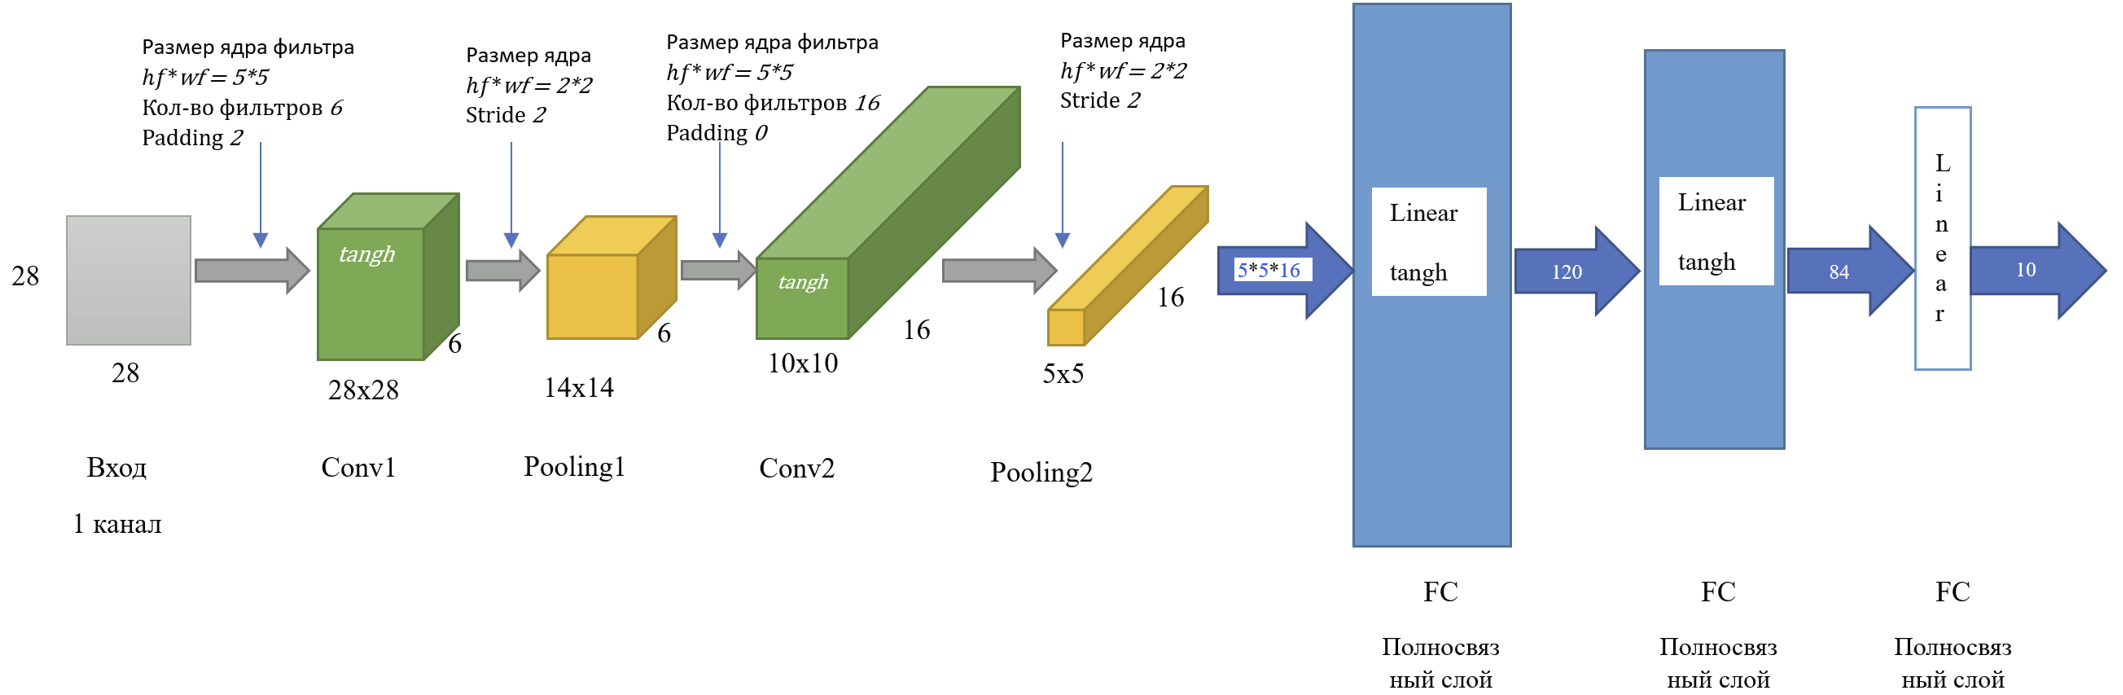


В архитектуре нейронной сети, показанной выше:

**Слой Conv1** представляет собой сверточный слой с шестью картами признаков, размер которых составляет 28 × 28, функция активации tangh;
**Слой Pooling1** – это слой подвыборки (polling) с шестью картами признаков, размер которых составляет 14 × 14, функция активации AvgPooling;
**Слой Conv2** представляет собой сверточный слой с шестнадцатью характеристическими картами (слоями), размер которых составляет 10 × 10, функция активации tangh;
**Слой Pooling2** является слоем подвыборки с шестнадцатью характеристическими картами, размер которых составляет 5 × 5, функция активации AvgPooling;
**Слой FC** представляет собой полносвязанный слой, вход 5*5*16 нейронов (признаков), выход 120 нейронов, функция активации tangh;
**Слой FC** представляет собой полносвязанный слой, вход 120 нейронов (признаков), выход 84 нейронов, функция активации tangh;
**Слой FC** представляет собой полносвязанный слой, вход 84 нейронов (признаков), выход 10 нейронов;



In [1]:
# импортируем библиотеки

import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
import torchvision.transforms as transforms
from torchvision.datasets import Imagenette
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загружаем набор данных
train = Imagenette(root='./data/train', split='train', size="160px", transform=transform, download=True)
test = Imagenette(root='./data/val', split='val', size="160px", transform=transform, download=True)

# Создаем загрузчики данных
train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

# Пример итерации по данным
for images, labels in train_loader:
    print(f'Batch size: {images.shape}')  # Выводит размер батча изображений
    print(f'Labels: {labels.shape}')      # Выводит размер батча меток
    break                                 # Выход после первого батча


100%|██████████| 99.0M/99.0M [00:37<00:00, 2.61MB/s]


Extracting ./data/train\imagenette2-160.tgz to ./data/train


100%|██████████| 99.0M/99.0M [00:26<00:00, 3.77MB/s]


Extracting ./data/val\imagenette2-160.tgz to ./data/val
Batch size: torch.Size([32, 3, 96, 96])
Labels: torch.Size([32])


In [5]:
# Формируем x_train и y_train
x_train = []
y_train = []

for images, labels in train_loader:
    x_train.append(images)
    y_train.append(labels)

# Конвертируем в тензоры
x_train = torch.cat(x_train)  # Объединяем все изображения в один тензор
y_train = torch.cat(y_train)  # Объединяем все метки в один тензор

# Формируем x_test и y_test
x_test = []
y_test = []

for images, labels in test_loader:
    x_test.append(images)
    y_test.append(labels)

# Конвертируем в тензоры
x_test = torch.cat(x_test)  # Объединяем все тестовые изображения в один тензор
y_test = torch.cat(y_test)  # Объединяем все тестовые метки в один тензор

In [6]:
y_train

tensor([2, 5, 6,  ..., 9, 6, 0])

In [7]:
# Печатаем размеры полученных данных
print(f'x_train shape: {x_train.shape}')  # Размеры обучающих изображений
print(f'y_train shape: {y_train.shape}')  # Размеры обучающих меток
print(f'x_test shape: {x_test.shape}')    # Размеры тестовых изображений
print(f'y_test shape: {y_test.shape}')    # Размеры тестовых меток

x_train shape: torch.Size([9469, 3, 96, 96])
y_train shape: torch.Size([9469])
x_test shape: torch.Size([3925, 3, 96, 96])
y_test shape: torch.Size([3925])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

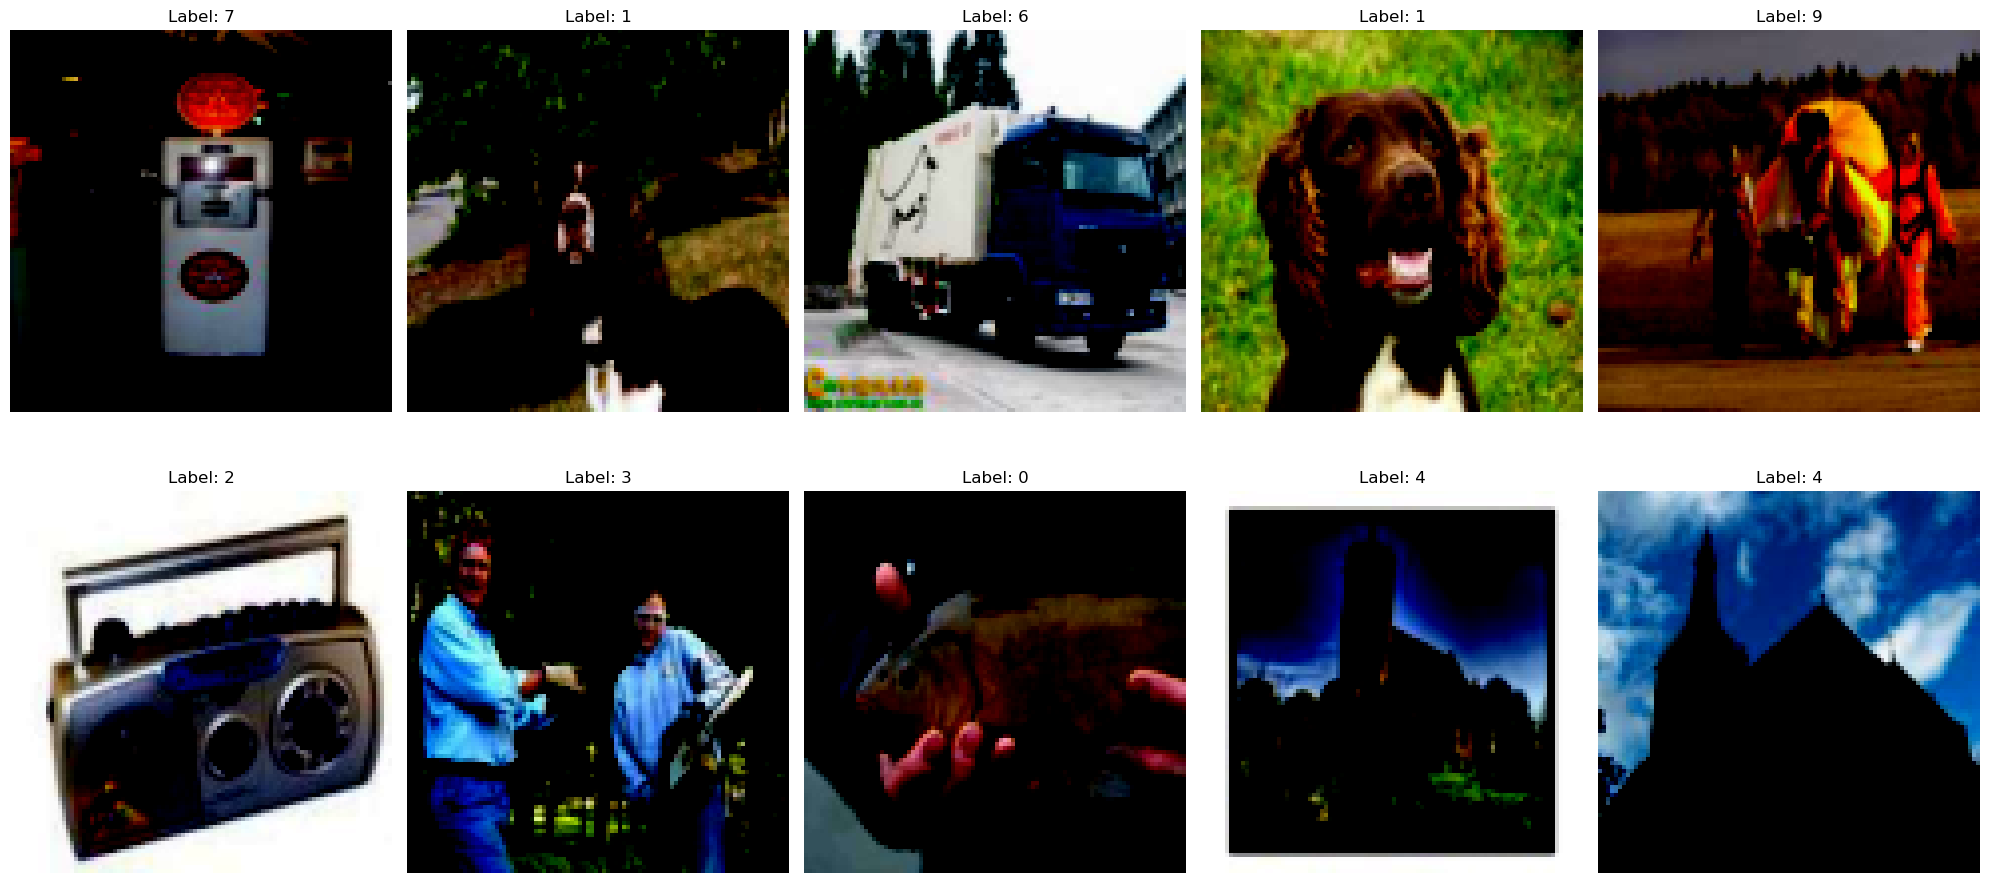

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры для выборки и визуализации
sample_size = 10  # количество изображений для визуализации

# Инициализация графика
plt.figure(figsize=(20, 10))

# Случайная выборка индексов изображений
indices = np.random.permutation(x_train.shape[0])[:sample_size]

for count, i in enumerate(indices):
    plt.subplot(2, 5, count + 1)  # Разделение на 2 строки и 5 колонок
    plt.imshow(x_train[i].permute(1, 2, 0).numpy(), cmap='viridis')  # Преобразуем (C, H, W) в (H, W, C) для отображения
    plt.title(f'Label: {y_train[i].item()}')  # Отображаем метку
    plt.axis('off')                           # Убираем оси

plt.tight_layout()
plt.show()


In [9]:
# сколько изображений в трейне и тесте
len(y_train), len(y_test)

(9469, 3925)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image:
[[[-0.79607844 -0.7882353  -0.79607844 ... -0.92156863 -0.92941177
   -0.92941177]
  [-0.79607844 -0.7882353  -0.79607844 ... -0.92156863 -0.92941177
   -0.92941177]
  [-0.7882353  -0.78039217 -0.7882353  ... -0.92156863 -0.92941177
   -0.92941177]
  ...
  [-0.38823527 -0.4352941  -0.4980392  ... -0.56078434 -0.54509807
   -0.5294118 ]
  [-0.12156862 -0.19215685 -0.24705881 ... -0.47450978 -0.5058824
   -0.5137255 ]
  [ 0.02745104 -0.01176471 -0.00392157 ... -0.44313723 -0.4588235
   -0.4823529 ]]

 [[-0.9372549  -0.92941177 -0.9372549  ... -0.9529412  -0.9607843
   -0.9607843 ]
  [-0.9372549  -0.92941177 -0.92941177 ... -0.9529412  -0.9607843
   -0.9607843 ]
  [-0.92941177 -0.92156863 -0.92156863 ... -0.9529412  -0.9607843
   -0.9607843 ]
  ...
  [-0.7647059  -0.8039216  -0.8509804  ... -0.88235295 -0.88235295
   -0.8666667 ]
  [-0.6392157  -0.7019608  -0.7411765  ... -0.84313726 -0.88235295
   -0.8901961 ]
  [-0.6        -0.62352943 -0.6        ... -0.8352941  -0.8509804
   -0

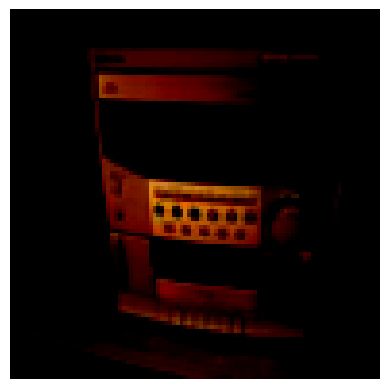

Label: 2


In [10]:
import matplotlib.pyplot as plt

# Номер изображения для отображения
im_number = 10

# Выводим массив изображения
print(f"image:\n{x_train[im_number].numpy()}")  # Преобразуем в numpy для вывода

# Отображаем изображение
plt.imshow(x_train[im_number].permute(1, 2, 0).numpy())  # Перемещаем оси для отображения (C, H, W) -> (H, W, C)
plt.axis('off')  # Убираем оси
plt.show()

# Выводим метку изображения
print(f'Label: {y_train[im_number].item()}')  # Используем item() для получения значения метки


In [11]:
# Номер изображения для анализа
im_number = 10

# Получаем изображение
image = x_train[im_number]

# Смотрим тип изображения
print(f"Тип изображения: {type(image)}")
print(f"Форма изображения: {image.shape}")  # Форма в формате (C, H, W)
print(f"Тип данных: {image.dtype}")

Тип изображения: <class 'torch.Tensor'>
Форма изображения: torch.Size([3, 96, 96])
Тип данных: torch.float32


In [12]:
x_train.shape

torch.Size([9469, 3, 96, 96])

In [13]:
x_test.shape

torch.Size([3925, 3, 96, 96])

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2)
        self.act1 = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2 = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = torch.nn.Linear(16 * 22 * 22, 120)
        self.act3 = torch.nn.Tanh()

        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = torch.nn.Tanh()

        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = LeNet5().to(device)

In [24]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [25]:
# Будем оптимизировать по 100 параметров за один проход (батч)
batch_size = 100

# Для хранения истории точности и потерь
test_accuracy_history = []
test_loss_history = []
train_loss_history = []

# Отправляем все выборки на устройство, на котором обучаем
x_test = x_test.to(device)
y_test = y_test.to(device)

# Количество эпох
epochs = 100

for epoch in range(epochs):
    # Перемешиваем порядок обучения
    order = np.random.permutation(len(x_train))

    for start_index in range(0, len(x_train), batch_size):
        # Обнуляем градиенты
        optimizer.zero_grad()

        # Получаем индексы для текущей пачки
        batch_indexes = order[start_index:start_index + batch_size]

        # Берём текущий батч данных
        x_batch = x_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        # Делаем предсказание
        preds = lenet5(x_batch)  # Можно использовать lenet5(x_batch) вместо lenet5.forward(x_batch)

        # Вычисляем значение потерь
        loss_value = loss(preds, y_batch)

        # Получаем градиенты
        loss_value.backward()

        # Выполняем оптимизацию
        optimizer.step()

    # Сохраняем данные о обучении
    train_loss_history.append(loss_value.item())  # Используем .item() для получения значения

    # Проверяем модель на тестовых данных
    with torch.no_grad():  # Отключаем вычисление градиентов для теста
        test_preds = lenet5(x_test)
        test_loss_history.append(loss(test_preds, y_test).item())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()  # .item() для получения скалярного значения
        test_accuracy_history.append(accuracy)

    # Выводим результаты текущей эпохи
    print(f"Epoch {epoch + 1}/{epochs} - Accuracy: {accuracy:.4f}")


Epoch 1/100 - Accuracy: 0.4199
Epoch 2/100 - Accuracy: 0.4535
Epoch 3/100 - Accuracy: 0.4538
Epoch 4/100 - Accuracy: 0.4627
Epoch 5/100 - Accuracy: 0.4655
Epoch 6/100 - Accuracy: 0.4573
Epoch 7/100 - Accuracy: 0.4420
Epoch 8/100 - Accuracy: 0.4395
Epoch 9/100 - Accuracy: 0.4278
Epoch 10/100 - Accuracy: 0.4222
Epoch 11/100 - Accuracy: 0.4122
Epoch 12/100 - Accuracy: 0.4079
Epoch 13/100 - Accuracy: 0.4120
Epoch 14/100 - Accuracy: 0.4115
Epoch 15/100 - Accuracy: 0.4097
Epoch 16/100 - Accuracy: 0.4104
Epoch 17/100 - Accuracy: 0.4107
Epoch 18/100 - Accuracy: 0.4097
Epoch 19/100 - Accuracy: 0.4099
Epoch 20/100 - Accuracy: 0.4092
Epoch 21/100 - Accuracy: 0.4102
Epoch 22/100 - Accuracy: 0.4097
Epoch 23/100 - Accuracy: 0.4110
Epoch 24/100 - Accuracy: 0.4107
Epoch 25/100 - Accuracy: 0.4092
Epoch 26/100 - Accuracy: 0.4102
Epoch 27/100 - Accuracy: 0.4104
Epoch 28/100 - Accuracy: 0.4099
Epoch 29/100 - Accuracy: 0.4094
Epoch 30/100 - Accuracy: 0.4087
Epoch 31/100 - Accuracy: 0.4082
Epoch 32/100 - Ac

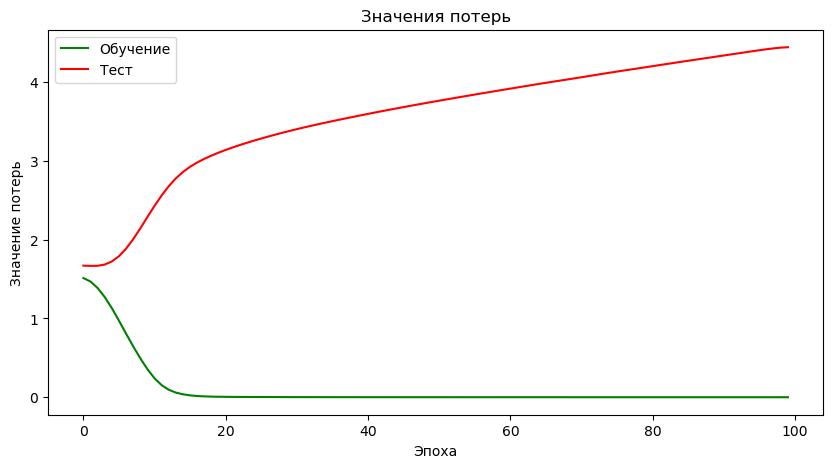

In [26]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Строим графики - функции потерь
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
ax.set(title='Значения потерь',
       xlabel='Эпоха',
       ylabel='Значение потерь')

train_loss_smoothed = gaussian_filter1d(train_loss_history, sigma=2)
ax.plot(train_loss_smoothed, color='green', label='Обучение')

test_loss_smoothed = gaussian_filter1d(test_loss_history, sigma=2)
ax.plot(test_loss_smoothed, color='red', label='Тест')

ax.legend()
plt.show()

C:\Users\yasur\AppData\Local\Temp\ipykernel_2464\2679742005.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


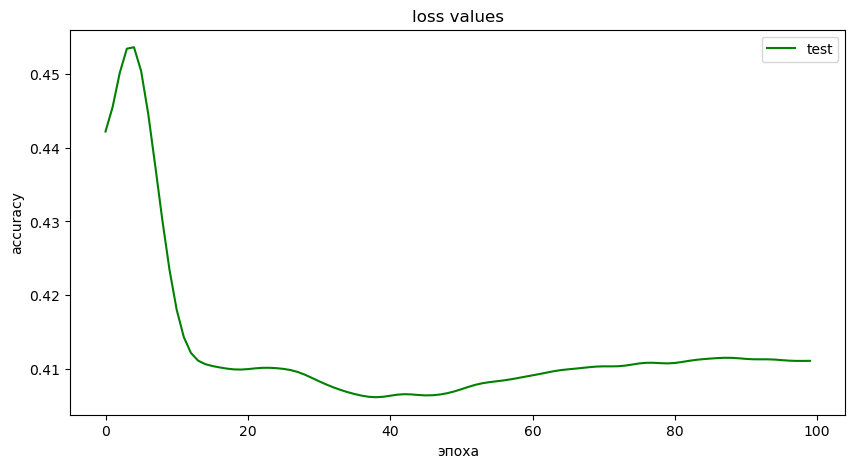

In [27]:
# График изменения accuracy на тестовых данных

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'accuracy')
test_accuracy_smoothed = gaussian_filter1d(test_accuracy_history, sigma=2)
ax.plot(test_accuracy_smoothed, color='green',  label='test')

ax.legend()
plt.show()


# Сохранение и использование модели

In [59]:
random_index = random.randint(0, len(test) - 1)

test_image, test_image_label = test[random_index]
print(test_image, test_image_label)

tensor([[[ 0.5686,  0.5686,  0.5765,  ...,  0.6000,  0.6000,  0.6000],
         [ 0.5608,  0.5686,  0.5686,  ...,  0.5922,  0.5922,  0.5922],
         [ 0.5529,  0.5608,  0.5686,  ...,  0.5843,  0.5843,  0.5843],
         ...,
         [-0.5137, -0.7255, -0.8431,  ..., -0.2941, -0.2471, -0.2314],
         [-0.6314, -0.6000, -0.5686,  ..., -0.4824, -0.3882, -0.3725],
         [-0.7098, -0.7176, -0.7020,  ..., -0.7098, -0.6235, -0.6000]],

        [[ 0.6706,  0.6706,  0.6784,  ...,  0.6941,  0.6941,  0.6941],
         [ 0.6627,  0.6706,  0.6706,  ...,  0.6863,  0.6863,  0.6863],
         [ 0.6549,  0.6627,  0.6706,  ...,  0.6784,  0.6784,  0.6784],
         ...,
         [-0.7176, -0.8196, -0.7804,  ..., -0.3569, -0.3569, -0.3569],
         [-0.6314, -0.5922, -0.5529,  ..., -0.5059, -0.4588, -0.4667],
         [-0.6941, -0.7020, -0.6784,  ..., -0.7333, -0.6863, -0.6941]],

        [[ 0.8039,  0.8039,  0.8118,  ...,  0.8039,  0.8039,  0.8039],
         [ 0.7961,  0.8039,  0.8039,  ...,  0

In [60]:
torch.save(test_image,'tensor.pt')

In [61]:
# смотрим размер тензора - изображения
test_image.size()

torch.Size([3, 96, 96])

In [62]:
# и размер того, что изначально скармливали нейронке.
# тензор подобного размера надо будет скормить нейронке для предсказания

x_test.size()

torch.Size([3925, 3, 96, 96])

In [63]:
# Установка dill - выполните это в вашем окружении
!pip install dill

# Сохранение модели с помощью dill
import dill

with open("model.dill", "wb") as dill_file:
    dill.dump(lenet5, dill_file)

In [64]:
# считываем модель, сохраненную в dill
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

ifile = open("model.dill", "rb")
modelp = dill.load(ifile)
ifile.close()

# загружаем наше изображение
test_data = torch.load('tensor.pt')

# смотрим, что пришло из dill файла
print(modelp)


LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): Tanh()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): Tanh()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=7744, out_features=120, bias=True)
  (act3): Tanh()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (act4): Tanh()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


C:\Users\yasur\AppData\Local\Temp\ipykernel_2464\31797657.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load('tensor.pt')


In [65]:
# смотрим тип модели
type(modelp)

__main__.LeNet5

In [66]:
print(test_data.shape)
test_data

torch.Size([3, 96, 96])


tensor([[[ 0.5686,  0.5686,  0.5765,  ...,  0.6000,  0.6000,  0.6000],
         [ 0.5608,  0.5686,  0.5686,  ...,  0.5922,  0.5922,  0.5922],
         [ 0.5529,  0.5608,  0.5686,  ...,  0.5843,  0.5843,  0.5843],
         ...,
         [-0.5137, -0.7255, -0.8431,  ..., -0.2941, -0.2471, -0.2314],
         [-0.6314, -0.6000, -0.5686,  ..., -0.4824, -0.3882, -0.3725],
         [-0.7098, -0.7176, -0.7020,  ..., -0.7098, -0.6235, -0.6000]],

        [[ 0.6706,  0.6706,  0.6784,  ...,  0.6941,  0.6941,  0.6941],
         [ 0.6627,  0.6706,  0.6706,  ...,  0.6863,  0.6863,  0.6863],
         [ 0.6549,  0.6627,  0.6706,  ...,  0.6784,  0.6784,  0.6784],
         ...,
         [-0.7176, -0.8196, -0.7804,  ..., -0.3569, -0.3569, -0.3569],
         [-0.6314, -0.5922, -0.5529,  ..., -0.5059, -0.4588, -0.4667],
         [-0.6941, -0.7020, -0.6784,  ..., -0.7333, -0.6863, -0.6941]],

        [[ 0.8039,  0.8039,  0.8118,  ...,  0.8039,  0.8039,  0.8039],
         [ 0.7961,  0.8039,  0.8039,  ...,  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


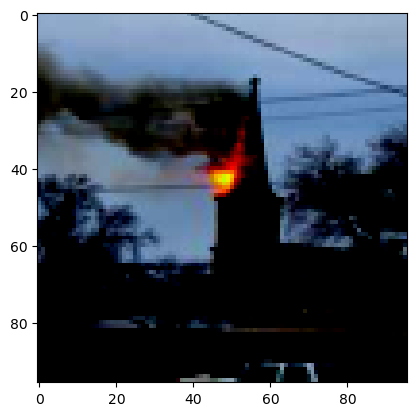

In [67]:
# Предположим, что test_data - это тензор PyTorch с формой (3, 96, 96)
# Сначала убедитесь, что вы переместили его на CPU, если он на GPU
test_data = test_data.cpu()

# Измените размерность
test_data = test_data.permute(1, 2, 0)  # Теперь будет (96, 96, 3)

# Теперь можно отобразить изображение
plt.imshow(test_data)
plt.show()

In [68]:
# переводим входной тензор-изображение в тензор нужного нам размера
t_data = torch.tensor([test_data.numpy()])

In [69]:
# проверяем
t_data.shape

torch.Size([1, 96, 96, 3])

In [70]:
# проверяем, на чем можем считать
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# отправляем туда модель
modelp.to(dev)
model_data = modelp.to(dev)

# тензор-изображение тоже
t_data = t_data.to(dev)

In [71]:
# делаем предсказание
# При условии, что t_data в форме (1, 96, 96, 3)
t_data = t_data.permute(0, 3, 1, 2)  # Преобразует в (1, 3, 96, 96)

# Теперь проводим предсказание
preds = modelp.forward(t_data)

In [72]:
# в каком виде получаем предсказание. Это вектор 10x1 с вероятностями принадлежности объекта к определенному классу
print(preds)

tensor([[-0.0451, -7.0455, -2.5099,  1.5199, 11.0003, -8.6108,  4.6887,  0.5724,
         -3.6399,  6.4593]], grad_fn=<AddmmBackward0>)


In [73]:
# выбираем максимальную вероятность, как результат предсказания.
# Не забывая отправить на cpu
prediction = np.argmax(preds.to('cpu').detach().numpy(),axis=1)

In [75]:
# смотрим, что предсказалось
if prediction == test_image_label:
    print("Предсказали верно.")
else:
    print("Предсказали неверно.")

Предсказали верно.
